In [20]:
from coffea.nanoevents import TreeMakerSchema, BaseSchema, NanoEventsFactory
import uproot as up
import pandas as pd
import numpy as np
import awkward as ak
import mplhep as hep
hep.style.use(hep.style.CMS)
import matplotlib.pyplot as plt

from helpers import get_summary_of_cuts

In [21]:
fname = '../output/ZmmYee/Data/crab_TTree_13TeV_fourmuon_2018BCD_v6.root'
savepath = 'plots/Data/test_coffea/'

In [22]:
events = NanoEventsFactory.from_root({fname: "ntuple"},
     schemaclass=BaseSchema,
     entry_stop=100,
).events()

In [23]:
columns = ['Event', 'Run', 'LumiBlock',
           'Mu_TriggerPath',
           'Z_soft1', 'Z_soft2',
           'Z_Vtx_Mass', 'Z_mass',
           'Z_pt1', 'Z_pt2', 'Z_eta1', 'Z_eta2',
           'Z_lowPt', 'Z_highPt',
           'Y_Vtx_Mass', 'Y_mass',
           'Y_pt1', 'Y_pt2', 'Y_eta1', 'Y_eta2',
           'Y_mvaIsoWP90_1', 'Y_mvaIsoWP90_2',
           'Z_Vtx_Prob', 'Y_Vtx_Prob',
           'FourL_mass', 'FourL_Vtx_Prob',
           'Y_lowPt', 'Y_highPt']

events = events[columns].compute()

### Define cut objects

In [24]:
cut_fake = (events.Y_mass > -1)

cut_unOrdered_Z = events.Z_pt1 > events.Z_pt2
cut_unOrdered_Y = events.Y_pt1 > events.Y_pt2
cut_unOrdered = cut_unOrdered_Z & cut_unOrdered_Y

cut_MuTrigger = events.Mu_TriggerPath
cut_Zsoft = events.Z_soft1 & events.Z_soft2
cut_MuTrigEnforce = events.Z_pt1 > 24
cut_dilepton_prob = (events.Y_Vtx_Prob > 0.01) & (events.Z_Vtx_Prob > 0.01)
cut_FourL_prob = events.FourL_Vtx_Prob > 0.01

cut_Pt = (events.Z_pt1 > 3.0) & (events.Z_pt2 > 3.0) & (events.Y_pt1 > 5.0) & (events.Y_pt2 > 5.0)
cut_eta = (abs(events.Z_eta1) < 2.4) & (abs(events.Z_eta2) < 2.4) & (abs(events.Y_eta1) < 2.5) & (abs(events.Y_eta2) < 2.5)
cut_detector = cut_Pt & cut_eta

cut_Ymass = (events.Y_mass > 8) & (events.Y_mass < 10)
cut_Zmass = (events.Z_mass > 70) & (events.Z_mass < 110)

cut_YmvaIsoHighpT = events.Y_mvaIsoWP90_1
cut_YmvaIsoLowpT = events.Y_mvaIsoWP90_2
cut_YmvaIsoBoth = (events.Y_mvaIsoWP90_1) & (events.Y_mvaIsoWP90_2)

cut_FourLmass = (events.FourL_mass > 112) & (events.FourL_mass < 162)


In [25]:
cut_list = {
    "0": {"name": "Preselection", "mask": cut_fake},
    "1": {"name": "UnOrdered pT", "mask": cut_unOrdered},
    "2": {"name": "Muon Trigger", "mask": cut_MuTrigger},
    "3": {"name": "Soft Muons", "mask": cut_Zsoft},
    "4": {"name": "Muon Trigger Enforce", "mask": cut_MuTrigEnforce},
    "5": {"name": "Dilepton Vtx > 1%", "mask": cut_dilepton_prob, "var": ["Y_Vtx_Prob", "Z_Vtx_Prob"]},
    "6": {"name": "FourL Vtx > 1%", "mask": cut_FourL_prob, "var": ["FourL_Vtx_Prob"]},
    "7": {"name": "Detector acceptance", "mask": cut_detector},
    "8": {"name": "Y mass", "mask": cut_Ymass, "var": ["Y_mass"]},
    "9": {"name": "Z mass", "mask": cut_Zmass, "var": ["Z_mass"]},
    "10": {"name": "eleID High pT", "mask": cut_YmvaIsoHighpT, "var": ["Y_pt1"]},
    "11": {"name": "eleID Low pT", "mask": cut_YmvaIsoLowpT, "var": ["Y_pt2"]},
    "12": {"name": "eleID Both", "mask": cut_YmvaIsoBoth, "var": ["Y_pt1", "Y_pt2"]},
    "13": {"name": "FourL mass", "mask": cut_FourLmass, "var": ["FourL_mass"]}
}

dilepton_mass_cuts = [8, 9]
eleID_cuts = [10, 11, 12]

In [26]:
eleID_highPt = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13]
eleID_highPt_noMass = [0, 1, 2, 3, 4, 5, 6, 7, 10, 13]
eleID_lowPt = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13]
eleID_lowPt_noMass = [0, 1, 2, 3, 4, 5, 6, 7, 11, 13]
eleID_both = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13]
eleID_both_noMass = [0, 1, 2, 3, 4, 5, 6, 7, 12, 13]

### plots at specific cut point

#### Function definitions

In [27]:
def get_view_at(mycut, summary_dict):
    mycut_name = cut_list[str(mycut)]['name']

    # find the cut in summary dict
    cut_index = summary_dict['Cut'].index(mycut_name)
    n_events_after_cut = summary_dict['Events'][cut_index]

    view_index = cut_index-1
    view_index_name = summary_dict['Cut'][view_index]
    view_index_mask = summary_dict['Aggregated mask'][view_index]
    n_events_before_cut = summary_dict['Events'][view_index]

    cut_of_interest = events[view_index_mask]
    text_array = [view_index_name, mycut_name, n_events_before_cut, n_events_after_cut]

    return cut_of_interest, text_array

def make_hist(nbins, xlow, xhigh, values, labels, lines, fileName, xlabel, text_array):
    cut_name_at_plot, cut_name_after_plot, n_ev_before, n_eve_after = text_array
    
    unit = 'GeV' if 'eta' not in xlabel else ''
    
    plt.figure(figsize=(8, 8))
    
    for i, value in enumerate(values):
        plt.hist(value, bins=nbins, range=(xlow, xhigh), label=labels[i], alpha=0.5)
    
    for line in lines:
        plt.axvline(x=line, color='r')

    plt.text(0.5, 0.5, f"Drawn at: {cut_name_at_plot} ({n_ev_before})", fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.5, 0.45, f"Next cut: {cut_name_after_plot} ({n_eve_after})", fontsize=12, transform=plt.gca().transAxes)

    plt.xlabel(xlabel)
    plt.ylabel(f"Counts / {(xhigh-xlow)/nbins:.2f} {unit}")
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.savefig(f"{savepath}/{fileName}.png")

def make_hist2D(xvar, yvar, xlabel, ylabel, fileName, text_array):
    cut_name_at_plot, cut_name_after_plot, n_ev_before, n_eve_after = text_array
    
    plt.figure(figsize=(8, 8))

    plt.hist2d(xvar, yvar, bins=(50, 50), range=((-3, 3), (0, 50)))
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f"{savepath}/{fileName}.png")

In [28]:
def plot_dilepton_vertexing(cut_of_interest, text_array):
    Y_vtx_prob = ak.flatten(cut_of_interest['Y_Vtx_Prob'])
    Z_vtx_prob = ak.flatten(cut_of_interest['Z_Vtx_Prob'])

    nbins, xlow, xhigh = 100, 0, 1
    fileName = "vtx_prob_dilepton"
    values = [Y_vtx_prob, Z_vtx_prob]
    labels = ["Y", "Z"]
    lines = [0.01]
    xlabel = "Dilepton Vtx Prob"

    make_hist(nbins, xlow, xhigh, values, labels, lines, fileName, xlabel, text_array)


def plot_dielectron_inv_mass(cut_of_interest, text_array, isFitData=False):
    dielectron_mass = ak.flatten(cut_of_interest['Y_mass'])

    if isFitData:
        nameExt = 'fitData'
        lines = []
    else:
        nameExt = ''
        lines = [8, 10]

    nbins, xlow, xhigh = 20, 0, 12
    fileName = f"Y_mass {nameExt}"
    values = [dielectron_mass]
    labels = ["Y_mass"]
    xlabel = "Dielectron inv mass [GeV]"

    make_hist(nbins, xlow, xhigh, values, labels, lines, fileName, xlabel, text_array)


def plot_dimuon_inv_mass(cut_of_interest, text_array, isFitData=False):
    dimuon_mass = ak.flatten(cut_of_interest['Z_mass'])

    if isFitData:
        nameExt = 'fitData'
        lines = []
    else:
        nameExt = '' 
        lines = [70, 110]

    nbins, xlow, xhigh = 20, 60, 120
    fileName = f"Z_mass {nameExt}"
    values = [dimuon_mass]
    labels = ["Z_mass"]
    xlabel = "Dimuon inv mass [GeV]"

    make_hist(nbins, xlow, xhigh, values, labels, lines, fileName, xlabel, text_array)


def plot_fourL_vertexing(cut_of_interest, text_array):
    FourL_vtx_prob = ak.flatten(cut_of_interest['FourL_Vtx_Prob'])

    nbins, xlow, xhigh = 100, 0, 1
    fileName = "vtx_prob_fourL"
    values = [FourL_vtx_prob]
    labels = ["FourL"]
    lines = [0.01]
    xlabel = "FourL Vtx Prob"

    make_hist(nbins, xlow, xhigh, values, labels, lines, fileName, xlabel, text_array)


def plot_muon_pt(cut_of_interest, text_array):
    muon_pt1 = ak.flatten(cut_of_interest['Z_pt1'])
    muon_pt2 = ak.flatten(cut_of_interest['Z_pt2'])

    nbins, xlow, xhigh = 75, 0, 150
    fileName = "Mu_pt"
    values = [muon_pt1, muon_pt2]
    labels = ["Mu_pt1", "Mu_pt2"]
    lines = [3.0]
    xlabel = "Mu pT [GeV]"

    make_hist(nbins, xlow, xhigh, values, labels, lines, fileName, xlabel, text_array)


def plot_electron_pt(cut_of_interest, text_array):
    ele_pt1 = ak.flatten(cut_of_interest['Y_pt1'])
    ele_pt2 = ak.flatten(cut_of_interest['Y_pt2'])

    nbins, xlow, xhigh = 50, 0, 50
    fileName = "Ele_pt"
    values = [ele_pt1, ele_pt2]
    labels = ["Ele_pt1", "Ele_pt2"]
    lines = [5.0]
    xlabel = "Ele pT [GeV]"

    make_hist(nbins, xlow, xhigh, values, labels, lines, fileName, xlabel, text_array)


def plot_muon_eta(cut_of_interest, text_array):
    muon_eta1 = ak.flatten(cut_of_interest['Z_eta1'])
    muon_eta2 = ak.flatten(cut_of_interest['Z_eta2'])

    nbins, xlow, xhigh = 30, -3, 3
    fileName = "Mu_eta"
    values = [muon_eta1, muon_eta2]
    labels = ["Mu_eta1", "Mu_eta2"]
    lines = [2.4]
    xlabel = "Mu eta"

    make_hist(nbins, xlow, xhigh, values, labels, lines, fileName, xlabel, text_array)

def plot_electron_eta(cut_of_interest, text_array):
    ele_eta1 = ak.flatten(cut_of_interest['Z_eta1'])
    ele_eta2 = ak.flatten(cut_of_interest['Z_eta2'])

    nbins, xlow, xhigh = 30, -3, 3
    fileName = "Ele_eta"
    values = [ele_eta1, ele_eta2]
    labels = ["Ele_eta1", "Ele_eta2"]
    lines = [2.5]
    xlabel = "Ele eta"

    make_hist(nbins, xlow, xhigh, values, labels, lines, fileName, xlabel, text_array)


def plot_electron_pt_vs_eta(cut_of_interest, text_array):
    xvar = ak.flatten(cut_of_interest['Y_eta1']).tolist()
    yvar = ak.flatten(cut_of_interest['Y_pt1']).tolist()

    fileName = "Ele1_eta_pt"
    xlabel = "Ele eta1"
    ylabel = "Ele pT1"
    make_hist2D(xvar, yvar, xlabel, ylabel, fileName, text_array)

    xvar = ak.flatten(cut_of_interest['Y_eta2']).tolist()
    yvar = ak.flatten(cut_of_interest['Y_pt2']).tolist()

    fileName = "Ele2_eta_pt"
    xlabel = "Ele eta2"
    ylabel = "Ele pT2"
    make_hist2D(xvar, yvar, xlabel, ylabel, fileName, text_array)


def plot_fourL_inv_mass(cut_of_interest, text_array):
    fourL_mass = ak.flatten(cut_of_interest['FourL_mass'])

    nameExt = text_array[0] if 'eleID' in text_array[0] else ''

    nbins, xlow, xhigh = 10, 70, 170
    fileName = f"FourL_mass_with {nameExt} cut"
    values = [fourL_mass]
    labels = ["FourL_mass"]
    lines = [112, 162]
    xlabel = "FourL inv mass [GeV]"

    make_hist(nbins, xlow, xhigh, values, labels, lines, fileName, xlabel, text_array)

In [29]:
def show_plots_at_each_cut(summary_dict):
    cut_of_interest, text_array = get_view_at(5, summary_dict)
    plot_dilepton_vertexing(cut_of_interest, text_array)

    cut_of_interest, text_array = get_view_at(6, summary_dict)
    plot_fourL_vertexing(cut_of_interest, text_array)

    cut_of_interest, text_array = get_view_at(7, summary_dict)
    plot_muon_pt(cut_of_interest, text_array)
    plot_electron_pt(cut_of_interest, text_array)
    plot_muon_eta(cut_of_interest, text_array)
    plot_electron_eta(cut_of_interest, text_array)
    plot_electron_pt_vs_eta(cut_of_interest, text_array)

    cut_of_interest, text_array = get_view_at(8, summary_dict)
    plot_dielectron_inv_mass(cut_of_interest, text_array, False)   

    cut_of_interest, text_array = get_view_at(9, summary_dict)
    plot_dimuon_inv_mass(cut_of_interest, text_array, False)

    cut_of_interest, text_array = get_view_at(13, summary_dict)
    plot_fourL_inv_mass(cut_of_interest, text_array)

def apply_cut_progression(cut_progression):
    summary_dict, summary_table = get_summary_of_cuts(events, cut_progression, cut_list)
    print("Summary of cuts")
    print(summary_table)

    show_plots_at_each_cut(summary_dict)

#### Plotting

In [30]:
summary_dict, summary_table = get_summary_of_cuts(events, eleID_highPt, cut_list)
summary_table

,Cut,Candidates,Events
0,Preselection,196969,148779
1,UnOrdered pT,196940,148765
2,Muon Trigger,97607,83870
3,Soft Muons,78618,71000
4,Muon Trigger Enforce,78482,70919
5,Dilepton Vtx > 1%,69379,62939
6,FourL Vtx > 1%,62762,57088
7,Detector acceptance,10491,9777
8,Y mass,1853,1780
9,Z mass,1419,1395


Summary of cuts
                     Cut  Candidates  Events
0           Preselection      196969  148779
1           UnOrdered pT      196940  148765
2           Muon Trigger       97607   83870
3             Soft Muons       78618   71000
4   Muon Trigger Enforce       78482   70919
5      Dilepton Vtx > 1%       69379   62939
6         FourL Vtx > 1%       62762   57088
7    Detector acceptance       10491    9777
8                 Y mass        1853    1780
9                 Z mass        1419    1395
10         eleID High pT          40      39
11            FourL mass          14      14


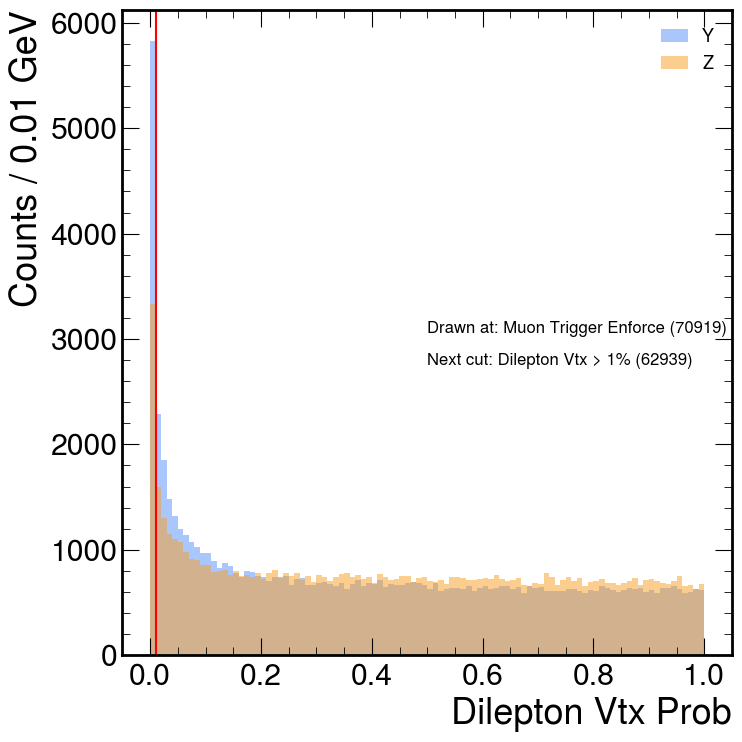

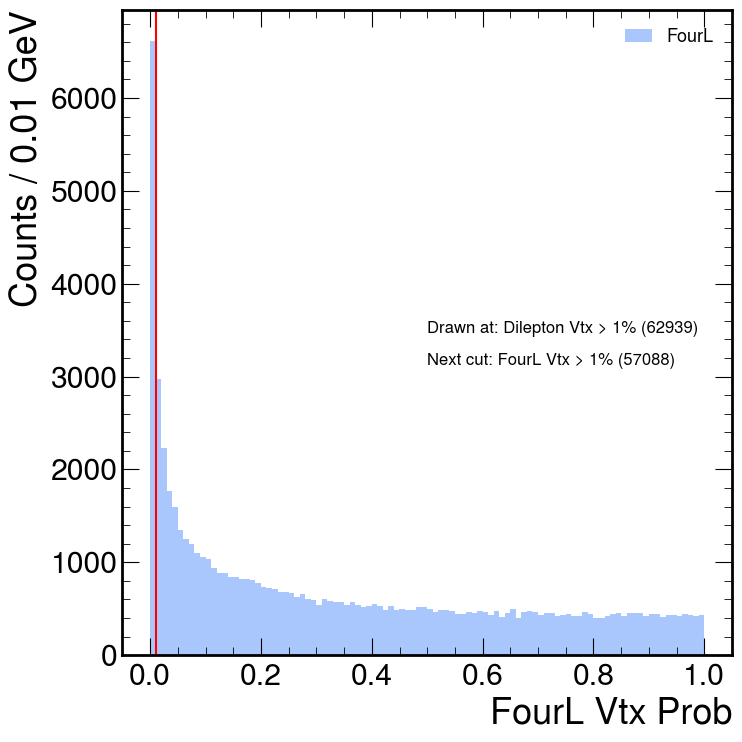

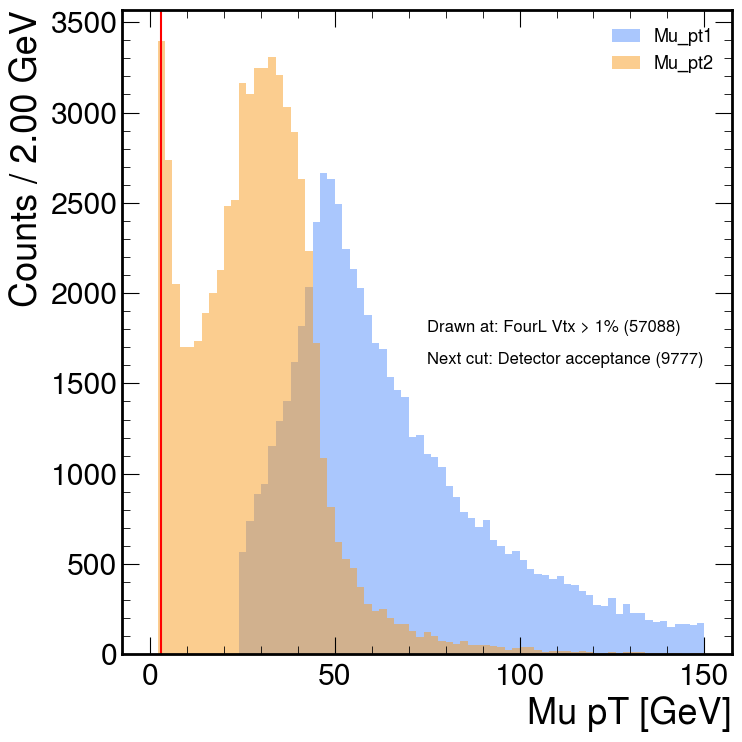

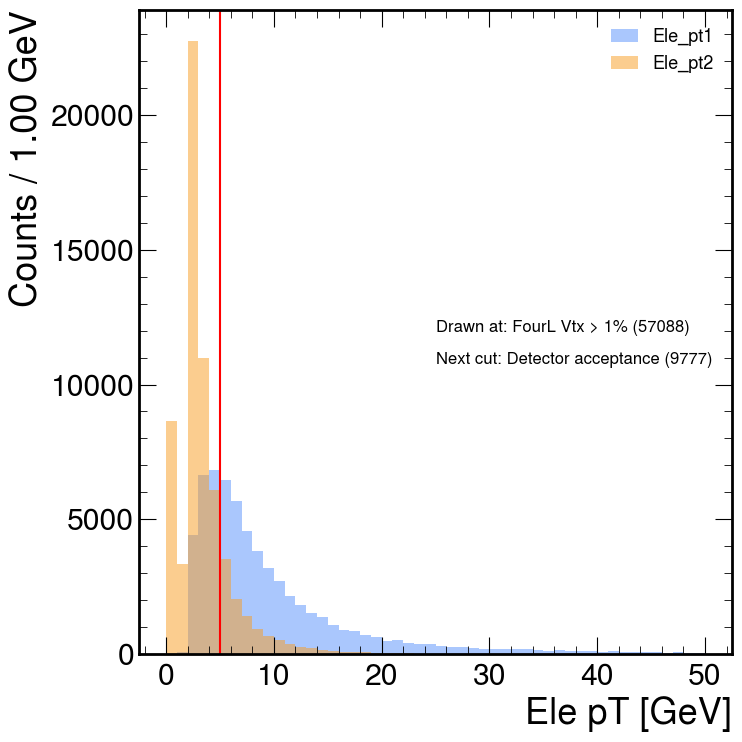

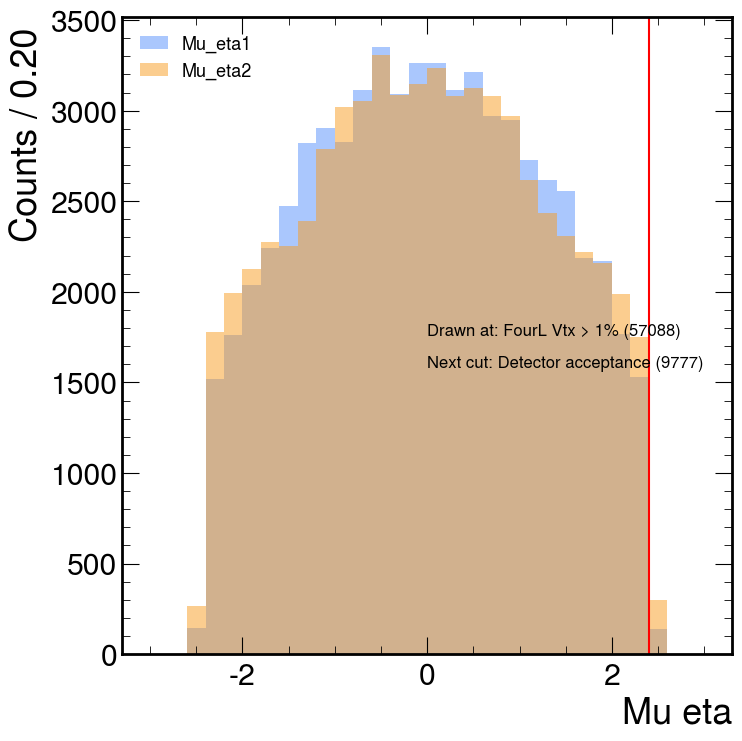

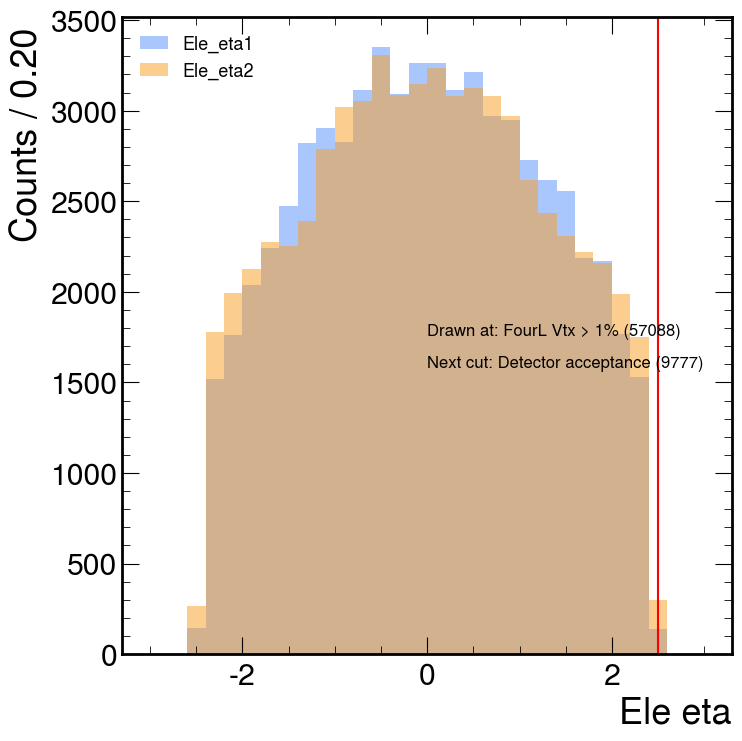

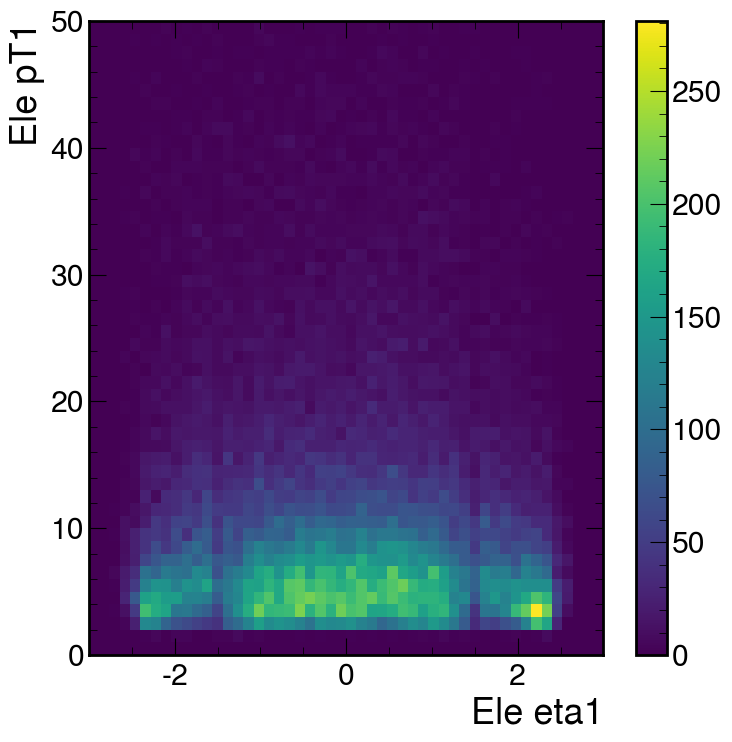

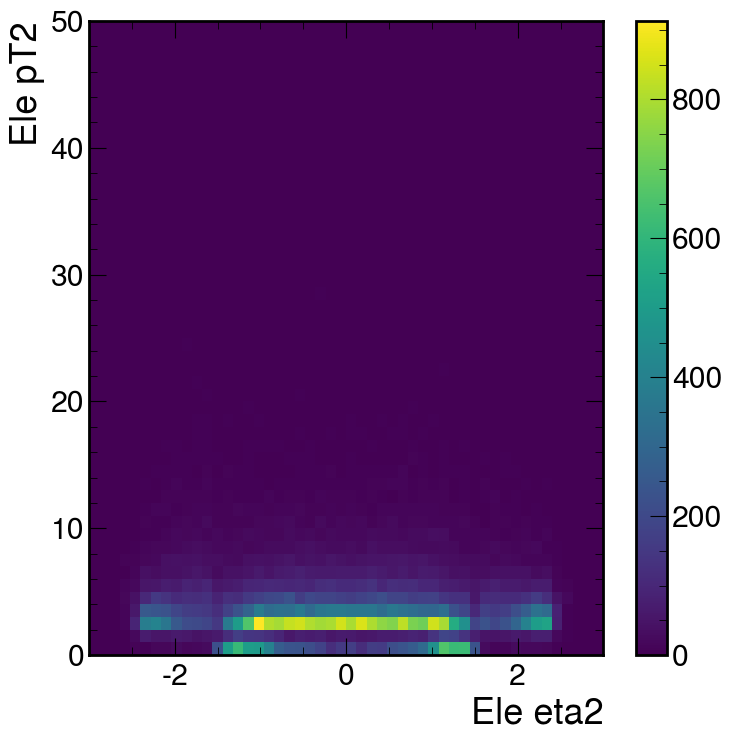

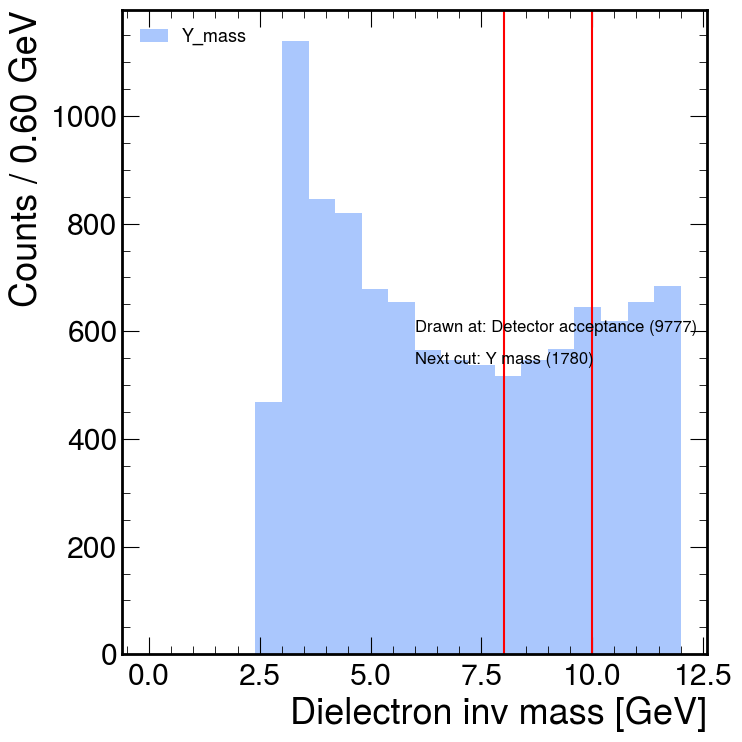

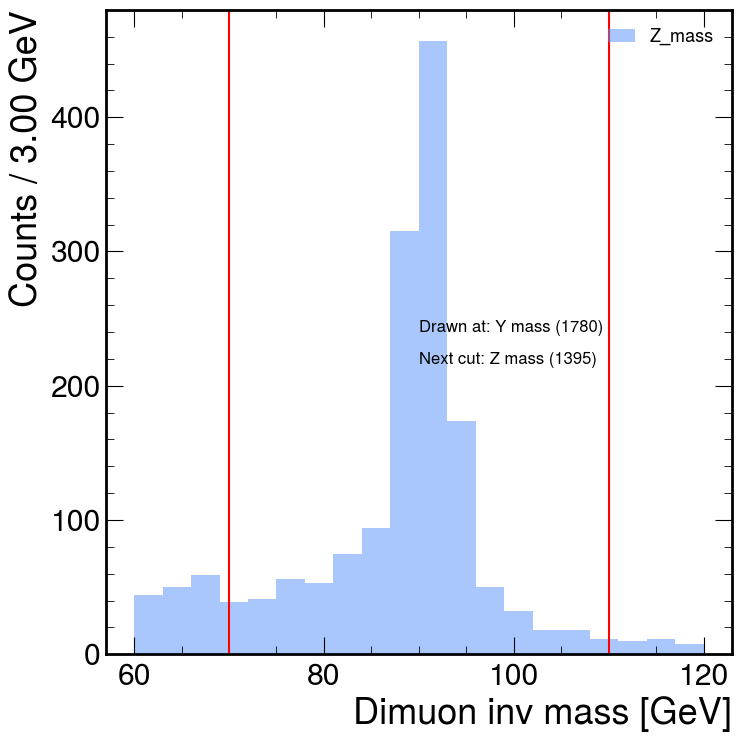

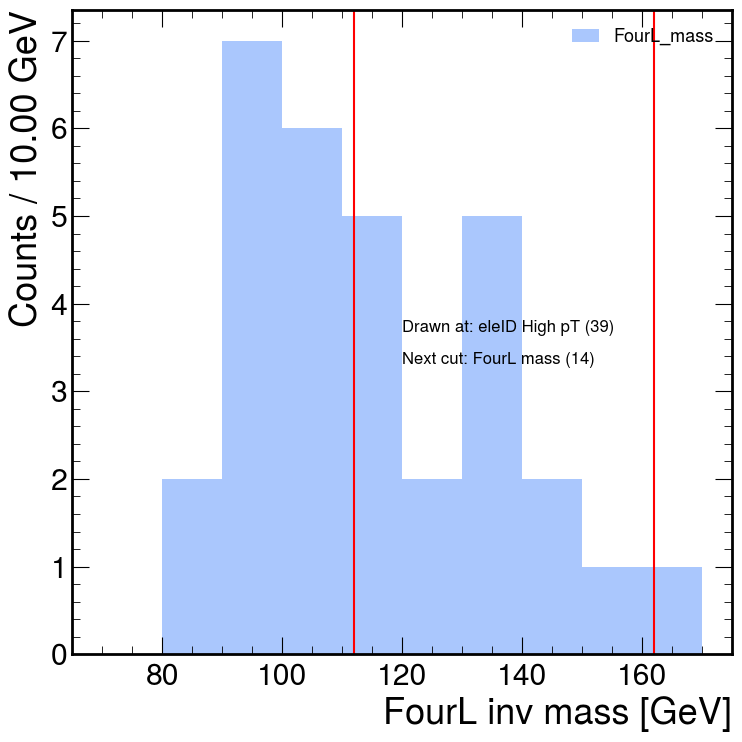

In [31]:
apply_cut_progression(eleID_highPt)

### Plots to show effects of cuts

#### Functions

In [32]:
def get_cut_name(global_index):
    cut_name = cut_list[str(global_index)]['name']
    return cut_name

In [33]:
def make_hist_compare(cuts, var, nbins, xlow, xhigh, xlabel, summary_dict):

    cut_names = list(map(get_cut_name, cuts))
    found = [item for item in cut_names if 'eleID' in item]
    
    nameExt = found[0] if len(found) > 0 else ''

    unit = 'GeV' if 'eta' not in xlabel else ''
    
    plt.figure(figsize=(8, 8))
    for cut in cuts:
        cut_name = cut_list[str(cut)]['name']
        cut_index = summary_dict['Cut'].index(cut_name)

        mask = summary_dict['Aggregated mask'][cut_index]
        nevents = summary_dict['Events'][cut_index]
        label = f"{summary_dict['Cut'][cut_index]}({nevents})"
    
        plt.hist(ak.flatten(events[var][mask]), bins=nbins, range=(xlow, xhigh), alpha=0.5, label=label)

    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(f"Counts / {(xhigh-xlow)/nbins:.2f} {unit}")
    plt.legend(fontsize=13)
    plt.savefig(f"{savepath}/prog_{var}_with {nameExt} cut.png")


def compare_dielectron_mass(cuts, summary_dict):
    nbins, xlow, xhigh = 60, 0, 12
    var = "Y_mass"
    xlabel = 'Dielectron inv mass [GeV]'
    make_hist_compare(cuts, var, nbins, xlow, xhigh, xlabel, summary_dict)

def compare_dimuon_mass(cuts, summary_dict):
    nbins, xlow, xhigh = 30, 70, 110
    var = "Z_mass"
    xlabel = 'Dimuon inv mass [GeV]'
    make_hist_compare(cuts, var, nbins, xlow, xhigh, xlabel, summary_dict)

def compare_fourL_mass(cuts, summary_dict):
    nbins, xlow, xhigh = 20, 100, 170
    var = "FourL_mass"
    xlabel = 'FourL inv mass [GeV]'
    make_hist_compare(cuts, var, nbins, xlow, xhigh, xlabel, summary_dict)

def compare_electron_pt(cuts, summary_dict):
    nbins, xlow, xhigh = 50, 0, 100
    var = "Y_pt1"
    xlabel = "High pT electron [GeV]"
    make_hist_compare(cuts, var, nbins, xlow, xhigh, xlabel, summary_dict)

    nbins, xlow, xhigh = 25, 0, 50
    var = "Y_pt2"
    xlabel = "Low pT electron [GeV]"
    make_hist_compare(cuts, var, nbins, xlow, xhigh, xlabel, summary_dict)

def compare_muon_pt(cuts, summary_dict):
    nbins, xlow, xhigh = 40, 5, 45
    var = "Z_pt1"
    xlabel = "High pT muon [GeV]"
    make_hist_compare(cuts, var, nbins, xlow, xhigh, xlabel, summary_dict)

    nbins, xlow, xhigh = 30, 5, 20
    var = "Z_pt2"
    xlabel = "Low pT muon [GeV]"
    make_hist_compare(cuts, var, nbins, xlow, xhigh, xlabel, summary_dict)

#### Plotting

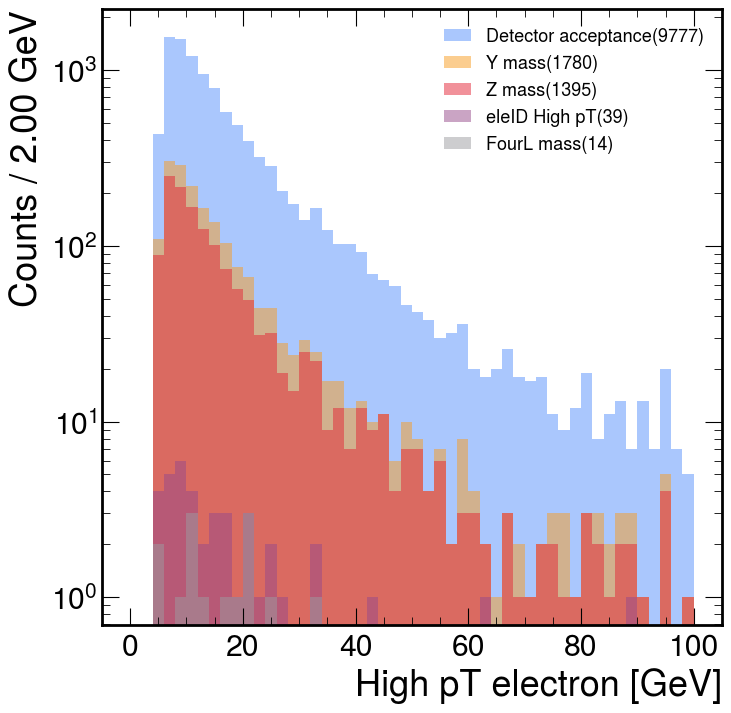

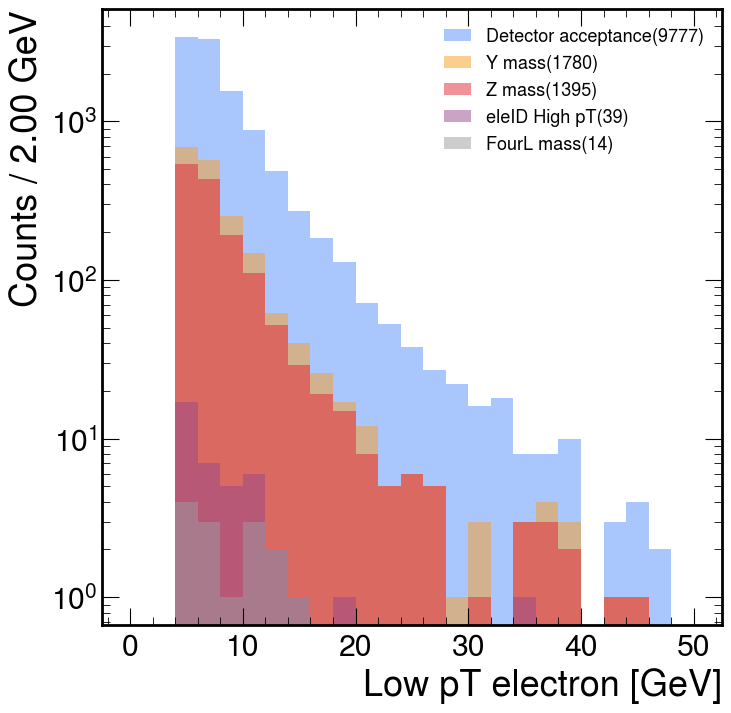

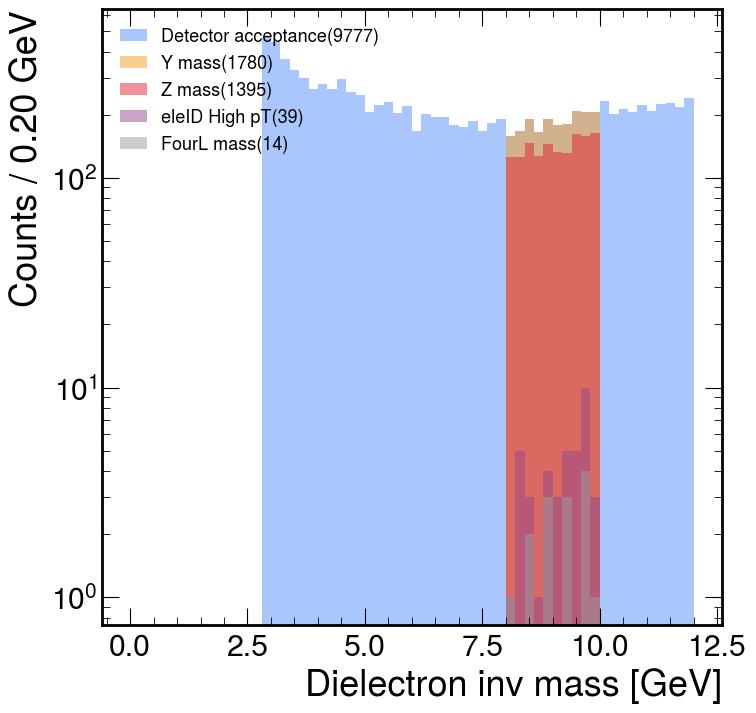

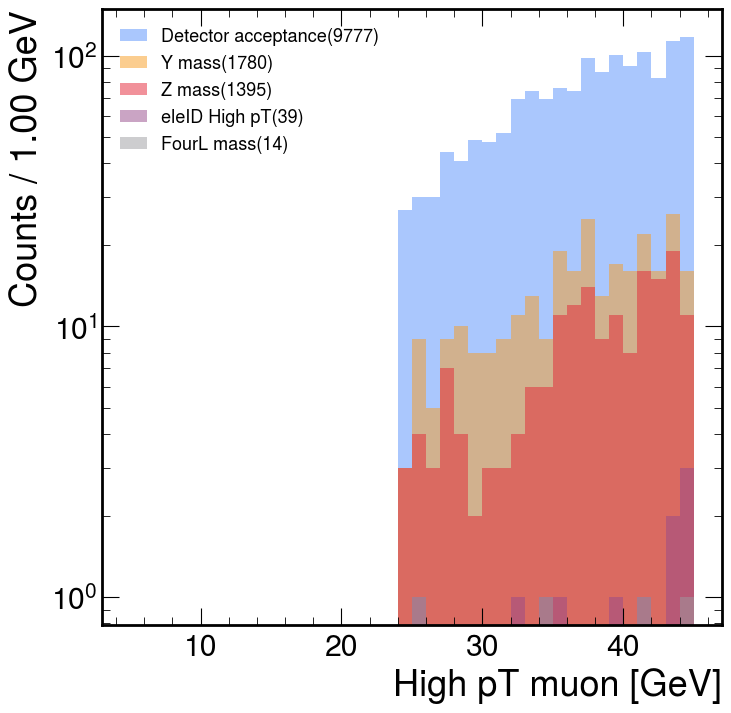

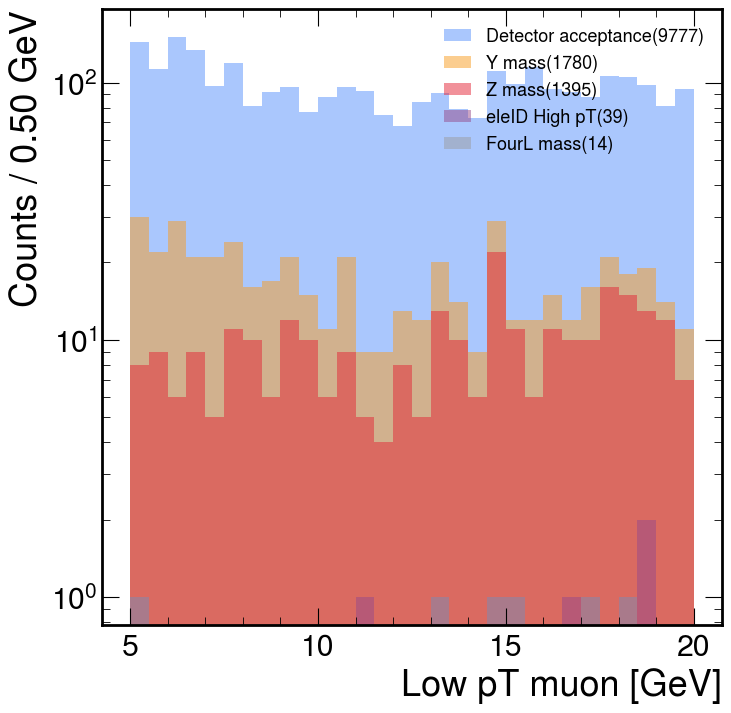

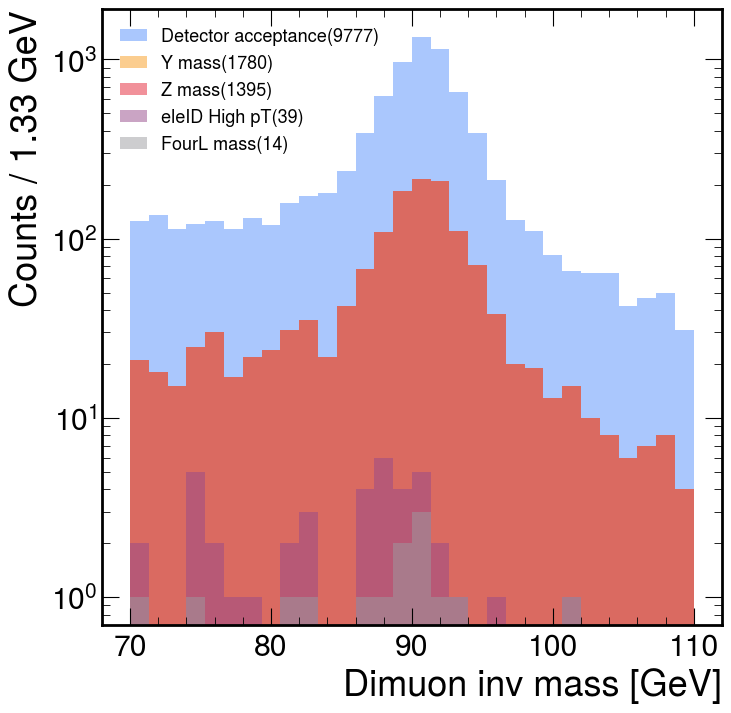

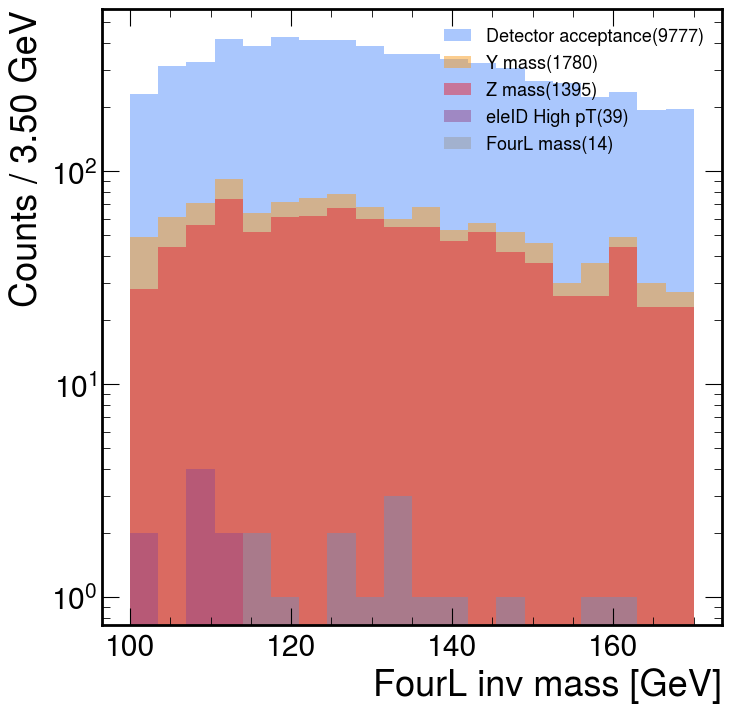

In [34]:
cuts = [7, 8, 9, 10, 13]
compare_electron_pt(cuts, summary_dict)
compare_dielectron_mass(cuts, summary_dict)
compare_muon_pt(cuts, summary_dict)
compare_dimuon_mass(cuts, summary_dict)
compare_fourL_mass(cuts, summary_dict)

### Gaussian Fitting

#### Functions

In [35]:
def make_fit_plots(summary_dict, cut_of_interest):
    found = [item for item in summary_dict['Cut'] if 'eleID' in item]

    if plot_at >= min(eleID_cuts) and len(found) > 0:
        fileExt = found[0]
    else:
        fileExt = ''

    Z_candidates = ak.flatten(cut_of_interest['Z_mass']).to_numpy()
    Z_mass = ROOT.RooRealVar("Z_mass", "Z_mass", 70, 110, "GeV")
    data = ROOT.RooDataSet.from_numpy({f"Z_mass": Z_candidates}, [Z_mass])

    frame = fit_unbinned_gauss_with_background(data, Z_mass, 20)

    # Draw the frame on the canvas
    canvas = ROOT.TCanvas("canvas", "Z Candidates")
    frame.Draw()
    canvas.Draw()
    canvas.SaveAs(f"{savepath}/fit_Z_gb_with {fileExt} cut.png")


    Y_candidates = ak.flatten(cut_of_interest['Y_mass']).to_numpy()
    Y_mass = ROOT.RooRealVar("Y_mass", "Y_mass", 2.8, 12, "GeV")
    data = ROOT.RooDataSet.from_numpy({f"Y_mass": Y_candidates}, [Y_mass])

    frame = fit_unbinned_double_gauss(data, Y_mass, 20)

    # Draw the frame on the canvas
    canvas = ROOT.TCanvas("canvas", "Y Candidates")
    frame.Draw()
    canvas.Draw()
    canvas.SaveAs(f"{savepath}/fit_Y_dg_with {fileExt} cut.png")

#### Plotting

In [36]:
summary_dict, summary_table = get_summary_of_cuts(events, eleID_highPt_noMass, cut_list)

In [37]:
plot_at = 10
cut_of_interest, text_array = get_view_at(plot_at, summary_dict)
# make_fit_plots(summary_dict, cut_of_interest)

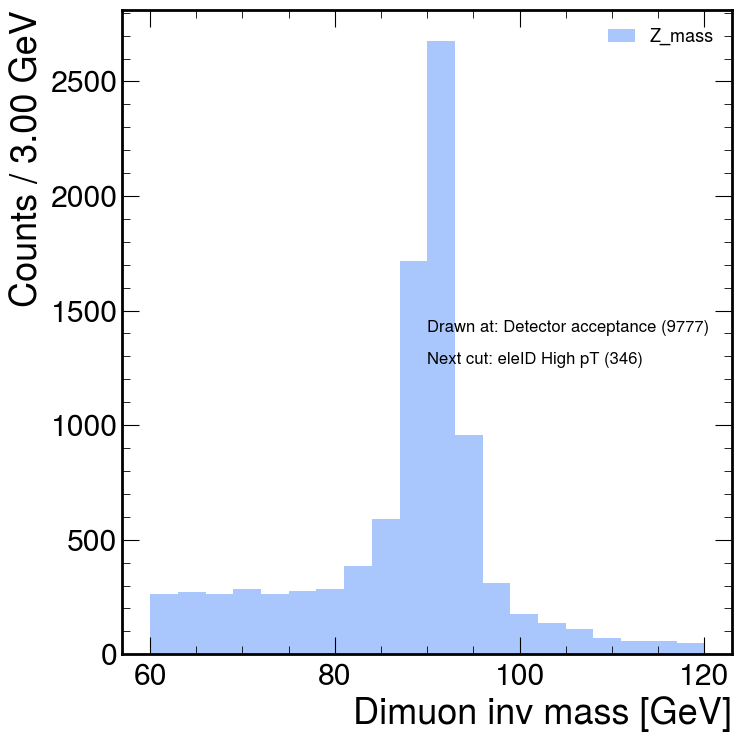

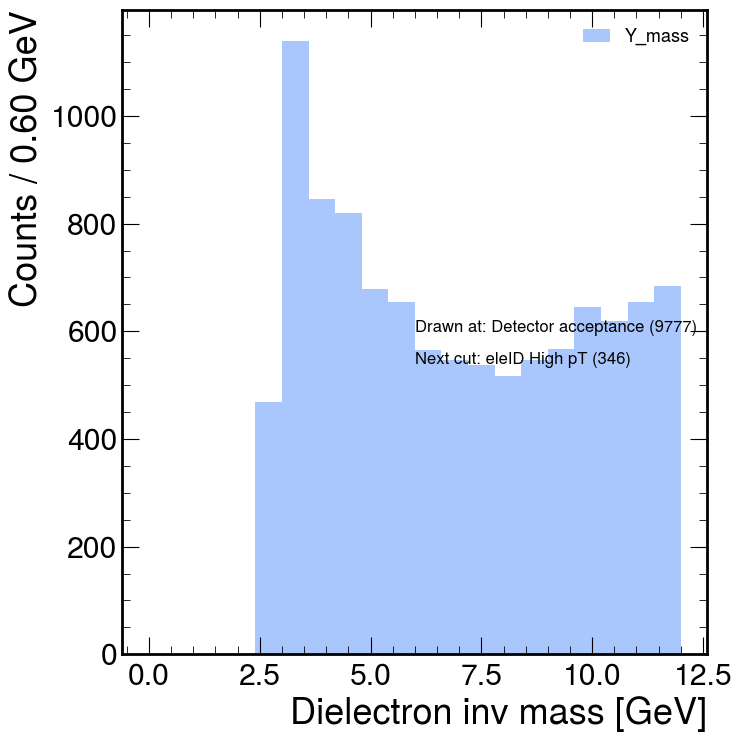

In [38]:
plot_dimuon_inv_mass(cut_of_interest, text_array, isFitData=True)
plot_dielectron_inv_mass(cut_of_interest, text_array, isFitData=True)